In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve,r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV
import shutil
import graphviz
import dtreeviz


In [5]:
# 读取数据
data = pd.read_csv(r"D:\ArcGISProjects\workspace\shbyq\resule_table\feature_dy_ph.csv")
print(len(data))
# 删除有缺失值的行
# data.dropna(inplace=True)
# len(data),data.columns

# 填补缺失值为列均值
data.fillna(data.mean(),inplace=True)

5909


In [51]:
# data.drop(columns=['pH'],inplace=True)

In [6]:
data

,pH,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,PlanCurvature,...,SecondMoment,Variance,PRE,SRA,TMP,VAP,WIND,BIO,LON,LAT
0,7.00,659.9,0.801314,3.689382,656.78375,3.116272,NaN,1.639718,0.871060,0.000283,...,0.259259,1.111111,98.500000,13031.250,16.483334,1.595833,1.550000,190.74300,477615.0,2912145.0
1,7.51,695.1,0.915071,3.437040,662.05050,33.049500,NaN,0.744609,5.670619,0.001733,...,0.358025,0.222222,98.500000,13031.250,16.483334,1.595833,1.550000,190.74300,477880.0,2912070.0
2,7.36,676.7,0.717656,4.712389,660.24620,16.453796,NaN,-0.612348,2.972762,-0.000313,...,0.802469,0.000000,98.833336,13019.667,16.358334,1.585833,1.566667,190.97212,477905.0,2911870.0
3,7.25,700.6,0.940011,2.176358,693.81040,6.789551,NaN,3.144440,4.590916,0.002804,...,0.283951,0.246914,98.833336,13019.667,16.358334,1.585833,1.566667,190.97212,477630.0,2911675.0
4,6.26,663.8,1.151546,2.137522,655.82210,7.977905,NaN,0.726125,11.618321,-0.000214,...,0.160494,1.111111,98.500000,13031.250,16.483334,1.595833,1.550000,190.74300,477545.0,2912550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,4.84,908.3,0.747713,0.502857,902.75116,5.548828,NaN,3.205612,4.960035,0.004812,...,0.160494,0.765432,103.250000,13015.667,15.508333,1.525833,1.700000,196.54535,472240.0,2878150.0
5905,4.42,885.2,1.011724,2.819842,870.78314,14.416870,NaN,-1.209290,9.109030,-0.004106,...,0.308642,0.222222,103.083336,13042.917,15.666667,1.540833,1.683333,196.45776,471850.0,2877405.0
5906,4.64,816.7,0.580022,5.819538,809.38430,7.315735,NaN,1.413066,8.945582,0.001866,...,0.283951,0.543210,101.166664,13005.167,15.516666,1.518333,1.650000,193.37679,475230.0,2896000.0
5907,4.72,873.2,0.307941,5.833926,872.23566,0.964355,NaN,-2.554014,24.575447,-0.015973,...,0.185185,4.913580,101.166664,13005.167,15.516666,1.518333,1.650000,193.37679,475320.0,2895595.0


In [3]:
duplicates = data.duplicated(subset=list(data.columns)[1:], keep='first')
df_duplicates = data[duplicates]
df_duplicates


,pH,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,PlanCurvature,...,SecondMoment,Variance,PRE,SRA,TMP,VAP,WIND,BIO,LON,LAT
92,4.80,950.89996,1.044289,1.070120,921.41644,29.483520,16.320465,-0.211999,23.000761,0.000248,...,0.432099,2.222222e-01,100.250000,12975.583,15.575000,1.515000,1.650000,191.93000,476870.0,2907905.0
139,5.74,979.40000,0.743108,5.176097,979.20730,0.192749,16.320465,2.530771,0.634588,0.000802,...,0.654321,9.094947e-13,99.333336,12856.833,15.066667,1.475000,1.725000,190.44110,457915.0,2920865.0
296,7.04,757.90000,0.631075,5.497787,757.90000,0.000000,16.320465,0.099274,15.408136,-0.002647,...,0.283951,1.728395e+00,99.000000,12944.583,15.858334,1.547500,1.633333,190.85130,464695.0,2913485.0
362,6.65,877.20000,0.772896,0.540402,876.81460,0.385437,16.320465,-1.612539,0.990988,-0.000740,...,0.333333,2.222222e-01,99.666664,12944.000,15.550000,1.514167,1.666667,191.59456,469595.0,2911865.0
534,5.52,975.00000,0.729002,5.742783,971.97095,3.029053,16.320465,3.821272,0.853921,0.000698,...,0.185185,1.432099e+00,99.583336,12889.083,15.050000,1.475000,1.716667,190.84326,457695.0,2914760.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5074,5.51,1076.10000,1.229890,3.538032,1068.96890,7.131104,16.320465,1.498587,19.739557,0.007742,...,0.506173,9.876544e-02,98.250000,12902.833,15.025000,1.480000,1.733333,188.74358,423850.0,2902665.0
5089,5.02,1022.00000,0.785200,6.283186,1069.13700,0.001221,47.138184,-2.869769,0.000657,-0.000010,...,0.259259,6.666667e-01,98.833336,12887.667,14.791667,1.457500,1.766667,189.44069,423425.0,2901725.0
5103,7.55,995.90000,1.386674,2.407701,961.17120,34.728820,16.320465,1.446183,22.019144,0.006522,...,0.358025,2.222222e-01,97.333336,12947.417,15.350000,1.514167,1.741667,187.76186,422460.0,2901145.0
5213,7.48,1217.50000,0.556142,4.691564,1207.04440,10.455566,16.320465,-0.257386,22.298914,-0.000021,...,0.283951,2.222222e-01,100.000000,12813.500,14.125000,1.398333,1.858333,190.40323,426920.0,2906950.0


In [4]:
# 去除重复数据
data.drop_duplicates(subset=list(data.columns)[1:], keep='first', inplace=True)

In [11]:
data

,pH,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,PlanCurvature,...,SecondMoment,Variance,PRE,SRA,TMP,VAP,WIND,BIO,LON,LAT
0,7.00,659.9,0.801314,3.689382,656.78375,3.116272,16.320465,1.639718,0.871060,0.000283,...,0.259259,1.111111,98.500000,13031.250,16.483334,1.595833,1.550000,190.74300,477615.0,2912145.0
1,7.51,695.1,0.915071,3.437040,662.05050,33.049500,16.320465,0.744609,5.670619,0.001733,...,0.358025,0.222222,98.500000,13031.250,16.483334,1.595833,1.550000,190.74300,477880.0,2912070.0
2,7.36,676.7,0.717656,4.712389,660.24620,16.453796,16.320465,-0.612348,2.972762,-0.000313,...,0.802469,0.000000,98.833336,13019.667,16.358334,1.585833,1.566667,190.97212,477905.0,2911870.0
3,7.25,700.6,0.940011,2.176358,693.81040,6.789551,16.320465,3.144440,4.590916,0.002804,...,0.283951,0.246914,98.833336,13019.667,16.358334,1.585833,1.566667,190.97212,477630.0,2911675.0
4,6.26,663.8,1.151546,2.137522,655.82210,7.977905,16.320465,0.726125,11.618321,-0.000214,...,0.160494,1.111111,98.500000,13031.250,16.483334,1.595833,1.550000,190.74300,477545.0,2912550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,4.84,908.3,0.747713,0.502857,902.75116,5.548828,16.320465,3.205612,4.960035,0.004812,...,0.160494,0.765432,103.250000,13015.667,15.508333,1.525833,1.700000,196.54535,472240.0,2878150.0
5905,4.42,885.2,1.011724,2.819842,870.78314,14.416870,16.320465,-1.209290,9.109030,-0.004106,...,0.308642,0.222222,103.083336,13042.917,15.666667,1.540833,1.683333,196.45776,471850.0,2877405.0
5906,4.64,816.7,0.580022,5.819538,809.38430,7.315735,16.320465,1.413066,8.945582,0.001866,...,0.283951,0.543210,101.166664,13005.167,15.516666,1.518333,1.650000,193.37679,475230.0,2896000.0
5907,4.72,873.2,0.307941,5.833926,872.23566,0.964355,16.320465,-2.554014,24.575447,-0.015973,...,0.185185,4.913580,101.166664,13005.167,15.516666,1.518333,1.650000,193.37679,475320.0,2895595.0


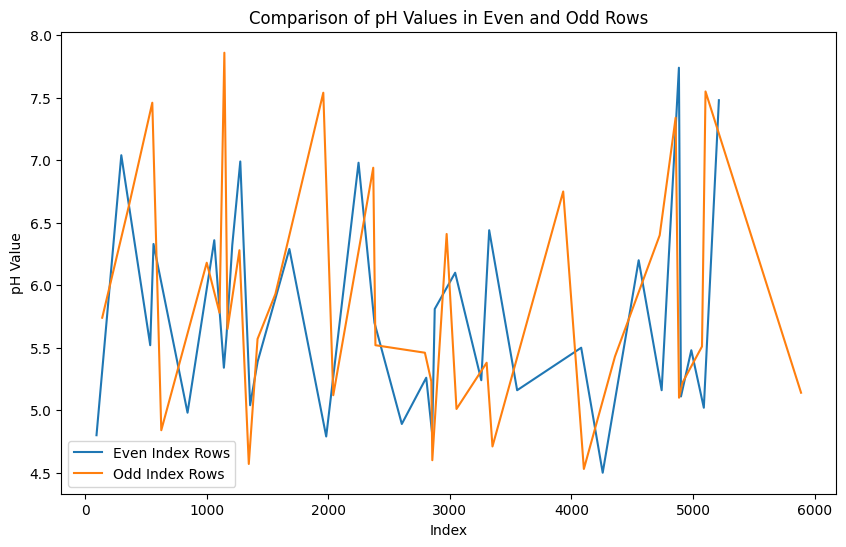

In [12]:
# 提取单数行（偶数索引）和双数行（奇数索引）的pH值
even_index_pH = df_duplicates.iloc[::2]['pH']  # 偶数索引行
odd_index_pH = df_duplicates.iloc[1::2]['pH']  # 奇数索引行

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(even_index_pH.index, even_index_pH, label='Even Index Rows')
plt.plot(odd_index_pH.index, odd_index_pH, label='Odd Index Rows')

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Comparison of pH Values in Even and Odd Rows')
plt.xlabel('Index')
plt.ylabel('pH Value')

# 显示图表
plt.show()

In [8]:
# 改写分类字段的类型
data['TDQS']=data['TDQS'].astype('category')

In [13]:
data.dtypes

pH                         float64
DEM                        float64
AnalyticalHillshading      float64
Aspect                     float64
ChannelNetworkBaseLevel    float64
ChannelNetworkDistance     float64
ClosedDepressions          float64
ConvergenceIndex           float64
LSFactor                   float64
PlanCurvature              float64
ProfileCurvature           float64
RelativeSlopePosition      float64
Slope                      float64
TopographicWetnessIndex    float64
TotalCatchmentArea         float64
ValleyDepth                float64
Contrast                   float64
Correlation                float64
Dissimilarity              float64
Entropy                    float64
Homogeneity                float64
Mean                       float64
ndvi                       float64
PCA_0                      float64
PCA_1                      float64
SecondMoment               float64
Variance                   float64
PRE                        float64
SRA                 

In [5]:
X = data.drop(columns='pH')
y = data['pH']

In [15]:
data.columns

Index(['pH', 'DEM', 'AnalyticalHillshading', 'Aspect',
       'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
       'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'PlanCurvature',
       'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
       'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
       'Contrast', 'Correlation', 'Dissimilarity', 'Entropy', 'Homogeneity',
       'Mean', 'ndvi', 'PCA_0', 'PCA_1', 'SecondMoment', 'Variance', 'PRE',
       'SRA', 'TMP', 'VAP', 'WIND', 'BIO', 'LON', 'LAT'],
      dtype='object')

In [16]:
len(data.columns)

35

In [12]:
X = data[[ 'BIO', 'PRE', 'SRA', 'TMP', 'VAP', 'WIN', 'NDVI', 'TDQS', 'LIGHT',
       'AnalyticalHillshading', 'Aspect', 'ChannelNetworkBaseLevel',
       'ChannelNetworkDistance', 'ClosedDepressions', 'ConvergenceIndex',
       'LSFactor', 'PlanCurvature', 'ProfileCurvature',
       'RelativeSlopePosition', 'Slope', 'TopographicWetnessIndex',
       'TotalCatchmentArea', 'ValleyDepth', 'DEM', 'LON', 'LAT','prediction_ph']]
y = data['pH']

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [18]:
# 定义随机森林超参数的取值范围
param_dist = {
    'n_estimators': np.arange(10, 1000, 10),
    'max_features': [1.0],
    'max_depth': [None] + list(np.arange(1, 28)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'bootstrap': [True, False]
}

# 创建随机森林回归器
clf = RandomForestRegressor()

# 使用RandomizedSearchCV来寻找最佳参数
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 打印最佳参数
print('Best Parameters: \n', random_search.best_params_)

# 使用最佳参数对测试集进行评估
best_clf = random_search.best_estimator_
score = best_clf.score(X_test, y_test)
print('Test accuracy:', score)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: 
 {'n_estimators': 700, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 16, 'bootstrap': True}
Test accuracy: 0.3216764595439052


In [7]:
# 使用最优参数训练RandomForestRegressor模型
rf = RandomForestRegressor(n_estimators=700,criterion='squared_error', min_samples_split=7, min_samples_leaf= 2, max_features=1.0, max_depth=16, bootstrap= True)
rf.fit(X_train,y_train)
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)
r2_score(y_test,y_test_pred),r2_score(y_train,y_train_pred)

(0.30806448222168836, 0.811302327343977)

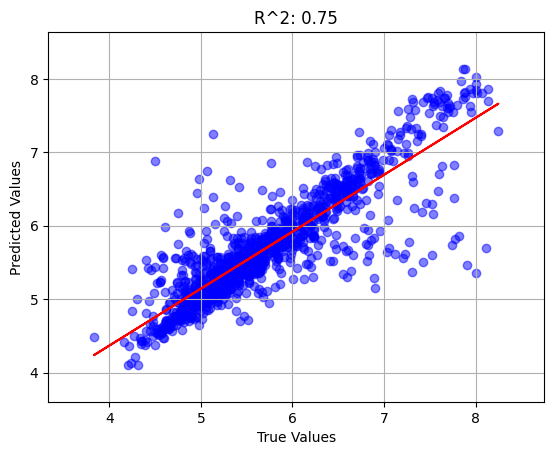

In [16]:
r2 = r2_score(y_test,y_test_pred)
# 画图
plt.scatter(y_test, y_test_pred, c='b', alpha=0.5)

fit = np.polyfit(y_test, y_test_pred,deg=1)
fit_fn = np.poly1d(fit) 
plt.plot(y_test, fit_fn(y_test), c='r')

plt.xlim([min(y_test)-0.5, max(y_test)+0.5])
plt.ylim([min(y_test_pred)-0.5, max(y_test_pred)+0.5])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('R^2: %.2f' % r2)
plt.grid()

plt.show()

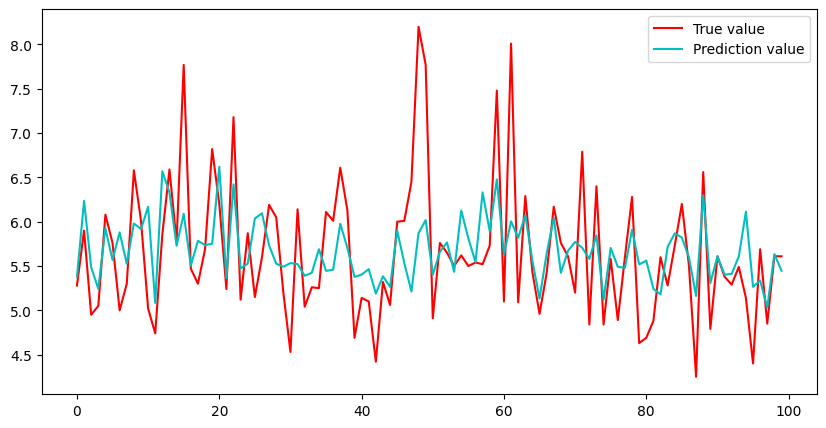

In [20]:
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test[:100])),y_test[:100],c='r',label='True value')
plt.plot(range(len(y_test_pred[:100])),y_test_pred[:100],c='c',label = 'Prediction value')
plt.legend()
plt.show()

In [8]:
mse_score = mean_squared_error(y_test, y_test_pred)
mae_score = mean_absolute_error(y_test, y_test_pred)
mape_score = mean_absolute_percentage_error(y_test, y_test_pred)
print('Mse:', mse_score,'Mae',mae_score,'Mape',mape_score)


Mse: 0.45748354181925033 Mae 0.5119336281609306 Mape 0.08943524749240161


In [22]:
rf.feature_importances_

array([0.05716792, 0.02624442, 0.02740405, 0.02348699, 0.05542096,
       0.00266119, 0.02169504, 0.022251  , 0.02736174, 0.03063498,
       0.06502196, 0.02655431, 0.02095588, 0.01905912, 0.0338404 ,
       0.00797608, 0.02659016, 0.003918  , 0.00911107, 0.00947204,
       0.02070206, 0.02620515, 0.02542105, 0.02919691, 0.00724265,
       0.01294878, 0.04198795, 0.02779904, 0.01827772, 0.01438891,
       0.01246772, 0.03772002, 0.09921724, 0.10959748])

In [9]:
a = rf.feature_importances_
a

array([0.05687006, 0.02805209, 0.02788529, 0.02397561, 0.05198656,
       0.00318064, 0.02167438, 0.02105149, 0.02647185, 0.03108424,
       0.0657101 , 0.02712665, 0.02165851, 0.01938861, 0.0327302 ,
       0.00782313, 0.02647589, 0.00402399, 0.00892277, 0.00949672,
       0.02083493, 0.02498265, 0.02465223, 0.02774493, 0.0073279 ,
       0.01345288, 0.04068336, 0.0272286 , 0.01767424, 0.01733261,
       0.01236124, 0.03927615, 0.10255963, 0.10829989])

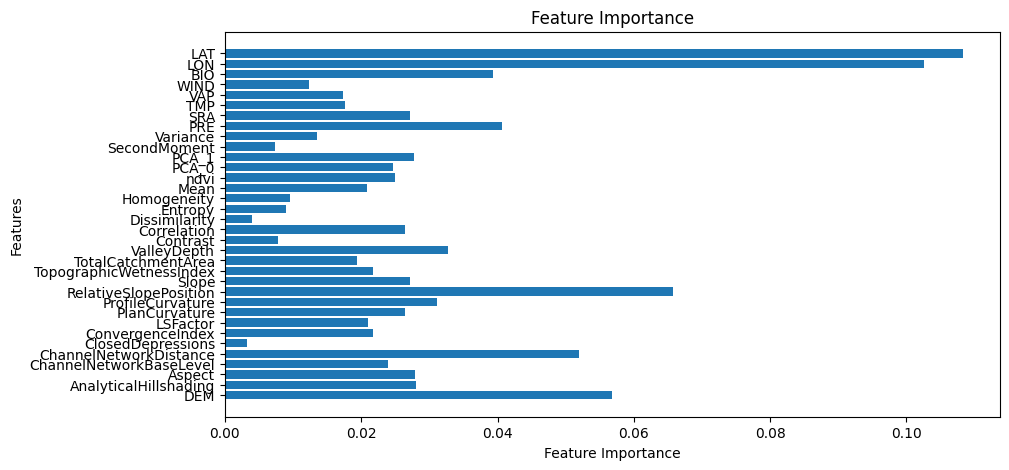

In [10]:
# 绘制特征重要性柱状图
plt.figure(figsize=(10, 5))
plt.barh(data.columns.drop('pH'), a)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [26]:
# 数据标准化后再训练
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 实例化标准化器

# scaler = StandardScaler()  # Z得分标准化（Standard Scaling）:将数据按属性（按列进行）减去其均值，并除以其标准差。结果的分布将具有均值为 0 和标准差为 1。

scaler = MinMaxScaler()  # 最小-最大标准化（Min-Max Scaling）:将所有特征缩放到 [0, 1] 范围内，或者是其他指定的范围。对异常值非常敏感。

# 加载数据
# scaler = RobustScaler()  # 稳健标准化（Robust Scaling）:使用四分位数范围来缩放数据，因此它对异常值不敏感。
for model in [StandardScaler(),MinMaxScaler(),RobustScaler()]:
    scaler = model

    # 对训练数据进行拟合和转换
    X_train_scaled = scaler.fit_transform(X_train)

    # 对测试数据进行转换
    X_test_scaled = scaler.transform(X_test)

    # 训练随机森林模型
    rf.fit(X_train_scaled, y_train)

    # 模型评估（例如，使用 R2 分数）
    r2_score = rf.score(X_test_scaled, y_test)
    print("R2 Score: ", r2_score)



R2 Score:  0.3105421229457931
R2 Score:  0.312515982408917
R2 Score:  0.30935016508279556


In [11]:
# 递归特征消除 (选择最佳组合特征)
from sklearn.feature_selection import RFE,RFECV

# RFE
selector = RFECV(rf,step=1,cv=5,n_jobs=4)
selector = selector.fit(X_train, y_train)

# 查看选中的特征
selected_features = selector.support_
# 计算测试集的 R2 分数
y_pred = selector.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Selected Features: ", selected_features)
print("Number of Selected Features: ", selector.n_features_)
print("R2 Score: ", r2)

Selected Features:  [ True False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False  True  True]
Number of Selected Features:  4
R2 Score:  0.30067645323374426


In [29]:
selected_features,selector.n_features_

(array([ True, False, False, False,  True, False, False, False, False,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False,  True,
        False, False, False, False, False,  True,  True]),
 9)

In [12]:
# 迭代优化 (选择最佳组合特征)

best_score = 0
best_features = None

# 尝试不同数量的特征
for i in range(1, X_train.shape[1] + 1):
    # RFE 选择特征
    selector = RFE(rf, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)

    # 预测并计算 R2 分数
    y_pred = selector.predict(X_test)
    score = r2_score(y_test, y_pred)

    # 更新最佳分数和特征
    if score > best_score:
        best_score = score
        best_features = selector.support_

print("Best R2 Score: ", best_score)
print("Best Features: ", best_features)

Best R2 Score:  0.3206427299126168
Best Features:  [ True  True False False  True False False False  True  True  True  True
 False False  True False False False False False False False  True  True
 False False  True  True False False False  True  True  True]


In [8]:
a = [True,  True, False, False,  True, False, False, False,  True,  True,  True,  True,
 False, False,  True, False, False, False, False, False, False, False,  True,  True,
 False, False,  True,  True, False, False, False,  True,  True,  True]
features_list = list(data.columns)
features_list.remove('pH')

In [9]:
features = [features_list[index] for index, item in enumerate(a) if item == True]


In [10]:
print(features),len(features)

['DEM', 'AnalyticalHillshading', 'ChannelNetworkDistance', 'PlanCurvature', 'ProfileCurvature', 'RelativeSlopePosition', 'Slope', 'ValleyDepth', 'PCA_0', 'PCA_1', 'PRE', 'SRA', 'BIO', 'LON', 'LAT']


(None, 15)